In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load MNIST Dataset

In [3]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='C:\\Users\\Asus\\Desktop\\Lab\\CNN', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='C:\\Users\\Asus\\Desktop\\Lab\\CNN', train=False, download=True, transform=transform)

100.0%


Extracting C:\Users\Asus\Desktop\Lab\CNN\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Asus\Desktop\Lab\CNN\MNIST\raw



100.0%


Extracting C:\Users\Asus\Desktop\Lab\CNN\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Asus\Desktop\Lab\CNN\MNIST\raw



100.0%


Extracting C:\Users\Asus\Desktop\Lab\CNN\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Asus\Desktop\Lab\CNN\MNIST\raw



100.0%

Extracting C:\Users\Asus\Desktop\Lab\CNN\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Asus\Desktop\Lab\CNN\MNIST\raw



In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\Asus\Desktop\Lab\CNN
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: C:\Users\Asus\Desktop\Lab\CNN
    Split: Test
    StandardTransform
Transform: ToTensor()

# Load dataset

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Define CNN

In [7]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [8]:
torch.manual_seed(42)
model = ConvolutionalNetwork()

# Define loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model

In [12]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

best_accu = 0
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            accu = trn_corr.item()*100/(10*b)
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {accu:7.3f}%')
    if accu > best_accu:
        best_accu = accu
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  
print(f'Best Accuracy: {best_accu}')

epoch:  0  batch:  600 [  6000/60000]  loss: 0.00040453  accuracy:  99.617%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.00045508  accuracy:  99.517%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.00004848  accuracy:  99.517%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.00229593  accuracy:  99.533%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.57134831  accuracy:  99.513%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00011524  accuracy:  99.494%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00001085  accuracy:  99.481%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00015735  accuracy:  99.475%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00055239  accuracy:  99.476%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00003091  accuracy:  99.463%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00002563  accuracy:  99.650%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00000174  accuracy:  99.608%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00069918  accuracy:  99.589%
epoch:  1  b

# Plot loss

In [27]:
# train_losses and test_losses to numpy
train_lo = [train.detach().numpy() for train in train_losses]
test_lo = [test.detach().numpy() for test in test_losses]


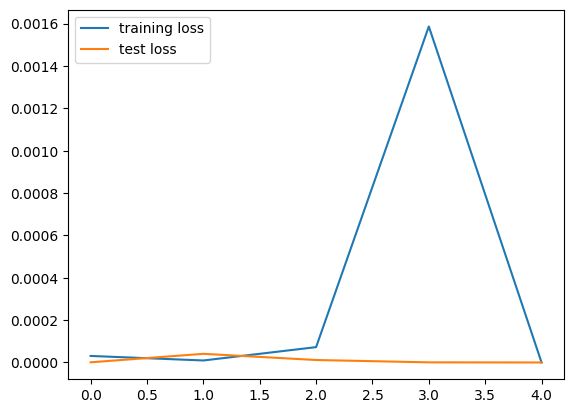

In [28]:
plt.plot(train_lo, label='training loss')
plt.plot(test_lo, label = 'test loss')
plt.legend()

# Plot Accuracy

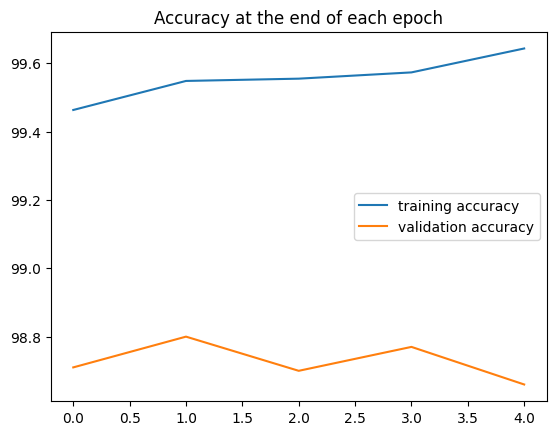

In [29]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# Evaluate Test Data

In [30]:
# Kiểm tra với toàn bộ tập test
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)


In [31]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9866/10000 =  98.660%


# Example

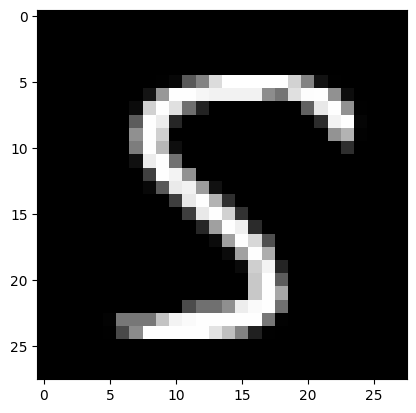

In [32]:
plt.imshow(test_data[333][0].reshape(28,28), cmap = 'gray')

In [34]:
model.eval()
with torch.no_grad():
    pred = model(test_data[333][0].view(1,1,28,28)).argmax()
print("Predicted value:", pred.item())

Predicted value: 5
